In [17]:
import numpy as np, pandas as pd, scipy as sp, sklearn as skl, matplotlib.pyplot as plt 
import re
%matplotlib inline

split2Words = lambda x:re.findall('[\w]+', x)

In [ ]:
train_orig = pd.read_csv('train.csv')
test_orig = pd.read_csv('test.csv') 
df= train_orig.copy()
dfTest = test_orig.copy()

In [61]:
def preproc(df):
    df.loc[:,'question1'] = df['question1'].fillna('')
    df.loc[:,'question2'] = df['question2'].fillna('')
    return df 

In [38]:
df[:10]

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [34]:
from nltk.corpus import stopwords
#stop = stopwords.words('english')
#print(stop)


In [98]:
# baseline models 
# unconditional 
from sklearn.metrics import log_loss
uncond = df.is_duplicate.mean()
log_loss(df.is_duplicate, np.repeat(uncond, len(df)), eps=1e-8)


0.65852738398443544

In [100]:

# unconditional 
dfTest = preproc(test_orig.copy())
dfTest.loc[:,'is_duplicate'] = uncond
dfTest[['test_id','is_duplicate']].to_csv('sub1.csv', index=False)

In [75]:
# count same word 

nOverlaps = lambda x,y: len(set(x).intersection(y))

df = train_orig.copy()
df = preproc(df)
df.loc[:,'q1'] = [split2Words(x) for x in df['question1']]
df.loc[:,'q2'] = [split2Words(x) for x in df['question2']]
df.loc[:,'nOL'] = [nOverlaps(x,y) for x,y in zip(df['q1'], df['q2'])]
df.loc[:,'OL%'] = df['nOL'] / np.array([max(len(x),len(y)) for x, y in zip(df['q1'], df['q2'])])
df.loc[:,'OL%round'] = df['OL%'].apply(lambda x:np.round(x,1))

,OL%round,dup%
0,0.0,0.016372
1,0.1,0.056746
2,0.2,0.186681
3,0.3,0.348204
4,0.4,0.483712
5,0.5,0.545068
6,0.6,0.570105
7,0.7,0.581427
8,0.8,0.520251
9,0.9,0.412046


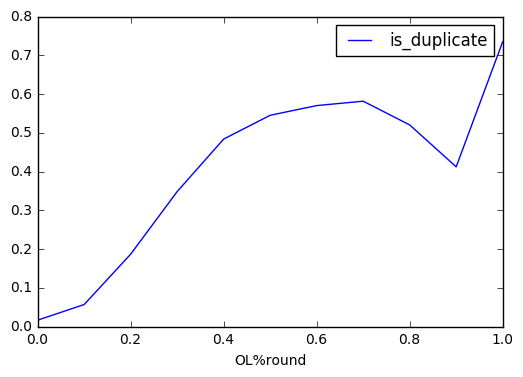

In [91]:
commonPct = df.groupby('OL%round').agg({'id':len, 'is_duplicate': (lambda x:x.sum()/np.float64(len(x)))})
commonPct[['is_duplicate']].plot()
commonPct = commonPct.reset_index(drop=False); del commonPct['id']
commonPct = commonPct.rename(columns= {'is_duplicate':'dup%'})
commonPct

In [99]:
df.loc[:,'pred'] = df['dup%']
log_loss(df.is_duplicate, df['pred'], eps=1e-8)


0.56390420059038759

In [104]:
#
df = preproc(test_orig.copy())
df.loc[:,'q1'] = [split2Words(x) for x in df['question1']]
df.loc[:,'q2'] = [split2Words(x) for x in df['question2']]
df.loc[:,'nOL'] = [nOverlaps(x,y) for x,y in zip(df['q1'], df['q2'])]
df.loc[:,'OL%'] = df['nOL'] / np.array([max(len(x),len(y)) for x, y in zip(df['q1'], df['q2'])])
df.loc[:,'OL%round'] = df['OL%'].apply(lambda x:np.round(x,1))
df = pd.merge(df, commonPct, on='OL%round', how='left')
df.loc[:,'is_duplicate'] = df['dup%'] + 0.3 * (uncond - df['dup%'])
df[['test_id','is_duplicate']].to_csv('sub1.csv', index=False)
# PL 0.5 